# Comparing PCA Dimensionality Reduction to Random Projection

Though Principal Components Analysis is a common choice for dimensionality reduction in machine learning, there isn't any reason to believe it's the optimal choice -- even in terms of computational efficiency.

This notebook demonstrates that, when using linear model on this dataset, there isn't a compelling reason to choose projection onto the principal component vectors over projection onto randomly chosen vectors!

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn.model_selection import train_test_split

In the
[Dimensionality Reduction Notebook](./Dimensionality\ Reduction.ipynb),
we were motivated to reduce the length of our data vectors because we had more data dimensions than we had observations, leading to
[overfitting](./Cross\ Validation\ Example.ipynb)
in our linear models.

Our goal when reducing dimensions is to
preserve information.
For example, we might want to be able to
recreate the original data vector from its reduced form
with as little error as possible --
we want to preserve information about the original data vector.

A common first choice for reducing dimensions is PCA,
or "Principal Components Analysis",
as described in detail in the
[Dimensionality Reduction Notebook](./Dimensionality\ Reduction.ipynb).

PCA is usually the first choice because it's
quick and the outcomes are interpretable.
It's also the best choice in certain cases.
However, these cases aren't common in machine learning.
PCA is the optimal choice, in the sense of preserving the most
information about the original vectors in the reduced vectors,
only if the data is distributed as a multivariate Gaussian.

But there's another issue with the use of PCA as a pre-processing step:
our overall goal isn't dimension reduction *per se*,
it's making our machine learning algorithm perform better!
That is, instead of preserving information about the original data vector
in our reduced vector, we want to preserve
the information in the original data vector
that is useful for predicting the targets!

Methods that directly attempt to solve the above problem
are called
[information bottleneck methods](https://en.wikipedia.org/wiki/Information_bottleneck_method).
Unfortunately, they require too much data to be
usable in practical machine learning models
(though [it has been claimed](https://arxiv.org/pdf/1503.02406.pdf)
that deep neural networks solve the information bottleneck problem).

Instead of finding the best choice of dimension reduction
by directly optimizing it,
we can instead use cross-validation to compare the performance of
the same model with different dimension reduction methods.

To illustrate that this cross-validation can sometimes find unintuitive results,
this notebook compares PCA to what you might think would be an overly-simple model:
[random projection](https://en.wikipedia.org/wiki/Random_projection).
In random projection,
instead of carefully selecting the vectors onto which we project our data,
we select them at random according to some distribution.
The most common choice is a Gaussian distribution.

Below, we run
[cross-validation](./Cross\ Validation\ Example.ipynb)
to determine the performance of randomly-chosen projections of
size ranging from one dimension to as many dimensions as we have data points.

Perhaps surprisingly, there doesn't seem to be any difference in performance on the test set between
random projections and projections onto the principal components!
Furthermore, we need our components to retain roughly 99% of the variance
before we get optimal test-set performance.
This would seem to indicate that the directions of large variance in our input data
are not the directions of variability that are useful for predicting our targets.

The cell below defines our cross-validation procedure
and the plots we'll use to display its results.
The code is included here, rather than squirreled away in a module,
for transparency's sake.
You can skip this cell and jump to the next block of text without missing anything crucial.

## Cross-Validation Functions

In [25]:
def run_CV(num_splits,transforms,X,y,model):
    
    train_scores = np.zeros((num_splits,len(transforms)))
    test_scores = np.zeros((num_splits,len(transforms)))

    for transform_idx, transform in enumerate(transforms):

        for split_idx in range(num_splits):

            X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,)
            transform.fit(X_train)
            transformed_X_train = transform.transform(X_train)
            transformed_X_test =  transform.transform(X_test)

            model.fit(transformed_X_train,y_train)

            train_score = model.score(transformed_X_train,y_train)
            test_score = model.score(transformed_X_test,y_test)

            train_scores[split_idx,transform_idx] = train_score
            test_scores[split_idx,transform_idx] = test_score
            
    return train_scores, test_scores

def transforms_from_schedule(to_keep_schedule,X,transform_type=""):
    
    transforms = []
    
    if transform_type == "PCA":
        transform = PCA
    elif transform_type == "random":
        transform = random_projection.GaussianRandomProjection
    else:
        raise ValueError("unknown transform "+transform_type)
    
    for to_keep in to_keep_schedule:
        transforms.append(transform(n_components=to_keep))
    
    return transforms

def plot_CV(schedule,train_scores,test_scores,transform_type):
    mean_train_scores = np.mean(train_scores,axis=0)
    mean_test_scores = np.mean(test_scores,axis=0)

    sd_train_scores = np.std(train_scores,axis=0,ddof=1)
    sd_test_scores = np.std(test_scores,axis=0,ddof=1)

    plt.errorbar(schedule,mean_train_scores,
                     yerr=sd_train_scores,
                 linewidth=4,alpha=0.75,
                 label=transform_type+'-Train',
                )

    plt.errorbar(schedule,mean_test_scores,
                     yerr=sd_test_scores,
                 linewidth=4,alpha=0.75,
                 label=transform_type+'-Test',
                linestyle='--')

def make_plot(schedule,train_scores,test_scores,transform_type="PCA"):
    
    plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    
    plot_CV(schedule,train_scores,test_scores,transform_type)
    
    plt.ylim([0,1]);

    plt.xlabel("Retained Dimensions");
    plt.ylabel("$R^2$")
    plt.legend(); plt.title("Train vs. Test Scores for " +transform_type+ " DR");
    
def get_best(test_scores,to_keep_schedule):
    
    mean_test_scores = np.mean(test_scores,axis=0)
    
    best_score_index = np.argmax(mean_test_scores)
    best_score = mean_test_scores[best_score_index]
    best_score_num_dimensions = to_keep_schedule[best_score_index]
    print("the best number of dimensions to keep is: "+ str(best_score_num_dimensions) +
          "\n with a score of: " + str(best_score) )

def produce_CV_plot(to_keep_schedule,num_splits,
                  X,y,
                  model=skl.linear_model.LinearRegression(),
                 transform_type="PCA"):
    
    transforms = transforms_from_schedule(to_keep_schedule,X,transform_type=transform_type)
    
    train_scores, test_scores = runCV(num_splits,transforms,X,y,model)
    
    make_plot(to_keep_schedule,train_scores,test_scores,transform_type=transform_type)
    get_best(test_scores,to_keep_schedule)
    
    return train_scores,test_scores

## Loading Data

In [12]:
train = pd.read_csv('../data/training.csv')

train.head()

,PIDN,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,...,REF7,RELI,TMAP,TMFI,Depth,Ca,P,pH,SOC,Sand
0,XNhoFZW5,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,...,-0.646673,1.687734,0.190708,0.056843,Topsoil,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,9XNspFTd,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,...,-0.646673,1.687734,0.190708,0.056843,Subsoil,-0.387442,-0.231552,-1.531538,-0.264023,1.692209
2,WDId41qG,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,...,-0.814516,1.806660,0.190708,0.056843,Topsoil,-0.248601,-0.224635,-0.259551,0.064152,2.091835
3,JrrJf1mN,0.261116,0.259767,0.258384,0.259001,0.261310,0.262417,0.260534,0.258039,0.257246,...,-0.814516,1.806660,0.190708,0.056843,Subsoil,-0.332195,-0.318014,-0.577548,-0.318719,2.118477
4,ZoIitegA,0.260038,0.258425,0.256544,0.257030,0.259602,0.260786,0.258717,0.256352,0.255902,...,-0.780242,0.430513,0.190708,0.056843,Topsoil,-0.438350,-0.010210,-0.699135,-0.310905,2.164148


In [13]:
data_columns = [column for column in train.columns if column.startswith('m')]
wavenumbers = [float(column.lstrip('m')) for column in data_columns]

output_columns = ["Ca","P","pH","SOC","Sand"]

X = train[data_columns].as_matrix()
y = train[output_columns].as_matrix()

## Running Cross-Validation and Comparing Results

After loading the data, we set our cross-validation schedule:
the values of the hyperparameter that we will check via cross-validation.
A hyperparameter is any setting of our model that determines
what result we get but which we don't directly fit via the data.
In our case, the hyperparameter is the number of retained dimensions.

In [ ]:
to_keep_schedule = [1,2,3,4,5,6,7,8,9,
                    10,20,30,50,
                    100,200,
                    1157,
                   ]

When performing cross-validation,
we artificially generate test sets by leaving some of our
training data out.
We then determine how well our algorithm performs on the held out data.

This is intended to simulate how well the algorithm would perform if we 
were to collect some data,
train on it,
and then collect new data.

The process of picking some data to keep in the training set
and some to put in the mock test set is called
*splitting*.
It's implemented by
`sklearn.model_selection.train_test_split`.

Just like the performance of our algorithm
on new data is a random variable
(after all, the new data is random!),
the performance on randomly-chosen held-out data
is also random.

Just like with data variables,
we're interested in the distribution of this random value:
what is it's center, and how is it spread?
And again just like with data variables,
we determine this by drawing multiple samples.
In this case, that means selecting multiple random splits
of the data into training and testing sets.

This value is determined by `num_splits` below.

In [ ]:
num_splits = 5

We now run our cross-validation procedure
for each of the hyperparameter settings.
We then plot the performance
(in this case, $R^2$, or "fraction of variance explained")
on the train and test sets
as a function of the hyperparameter.

Both values are plotted as mean ± standard deviation.

the best number of dimensions to keep is: 100
 with a score of: 0.71979925193


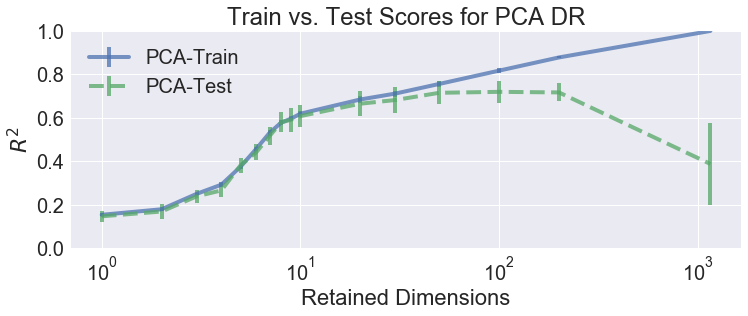

In [26]:
PCA_train_scores, PCA_test_scores = produce_CV_plot(to_keep_schedule,num_splits,
             X,y,
             );

We now repeat the above procedure for randomly-chosen projections.

Because the randomness of our choice of projection adds more randomness
to our estimate of the performance on the test set,
we increase the number of splits so that the quality of our estimate stays the same.

the best number of dimensions to keep is: 100
 with a score of: 0.724170172852


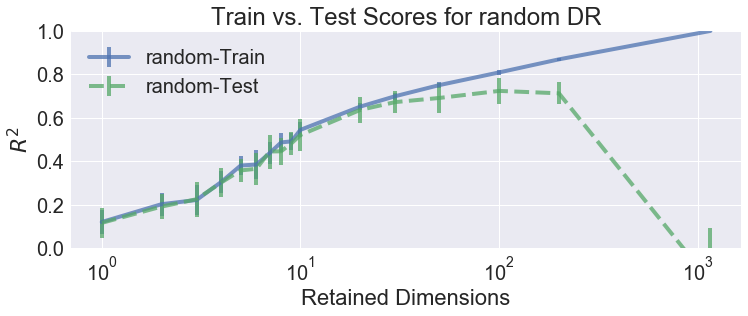

In [27]:
to_keep_schedule = [1,2,3,4,5,6,7,8,9,
                    10,20,30,50,
                    100,200,
                    1157,
                   ]
num_splits = 20

random_train_scores, random_test_scores = produce_CV_plot(to_keep_schedule,num_splits,
             X,y,transform_type="random"
             );

Strikingly, the overall shape of the plots is roughly the same, as is the performance of the best model.

The cell below puts both of the plots above onto the same axes.
Here we can see that PCA somewhat consistently outperforms random projection
for choices of between 5 and 10 dimensions retained,
but random projection catches up after that,
with both methods showing roughly equal performance
in the region where performance is best,
between 50 and 200 dimensions.

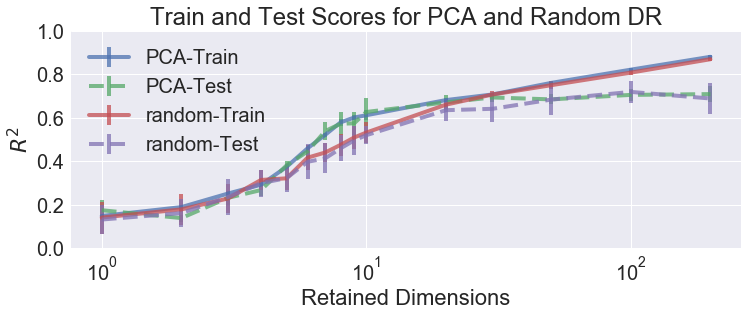

In [23]:
def comparison_plot(to_keep_schedule, PCA_train_scores, PCA_test_scores,
                                    random_train_scores, random_test_scores,
                                    keep_up_to=-1):

    keep_up_to = -1
    sub_schedule = to_keep_schedule[:keep_up_to];
    plt.figure(figsize=(12,4))
    ax = plt.subplot(111)

    plot_CV(sub_schedule,
       PCA_train_scores[:,:keep_up_to],PCA_test_scores[:,:keep_up_to],
       transform_type="PCA")

    plot_CV(sub_schedule,
       random_train_scores[:,:keep_up_to],random_test_scores[:,:keep_up_to],
       transform_type="random")

    plt.ylabel(r"$R^2$"); plt.xlabel("Retained Dimensions")
    plt.gca().set_xscale('log'); plt.ylim([0,1]); plt.legend();
    plt.title("Train and Test Scores for PCA and Random DR");
    
comparison_plot(to_keep_schedule, PCA_train_scores, PCA_test_scores,
                                    random_train_scores, random_test_scores,)

## Conclusions

Despite the fact that PCA
[does an excellent job reducing the dimensionality of this dataset](./Dimensionality Reduction.iypnb)
in terms of retaining variance,
it doesn't seem to do a much better job of preparing the data
for use in a linear model
than random projection.

Indeed, both models perform their best when the number of retained dimensions in around 100,
at which point there is a
[mathematical expectation](http://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html)
that the random projection will preserve lots of information about the input.

This would seem to indicate that the biggest variations in our input data
doesn't do a great job predicting variation in our output data.
Instead, very particular small changes to the input data are important,
and the only way to guarantee they are preserved in the reduced data vectors
is to preserve almost all of the variation in the input data
by retaining a fairly large number of dimensions.

The findings in this notebook demonstrate that,
just like more traditional hyperparameters,
dimensionality reduction choices,
and other pre-processing choices,
should be cross-validated,
in the absence of any guarantees
that they are optimal.